# M1 model 

M1 bruker hele datasettet til å predikere avgangskarakterer i mattematikk og portugisisk.

In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.metrics import confusion_matrix
import xgboost as xgb

from cf_matrix import make_confusion_matrix
from funcs import data_handling, train_test_split_M1, get_X_line

In [86]:
plt.style.use("ggplot")
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Importerer datasettet og deler det opp i trening og testdata. Y_test er sortert fra lavest til høyest.  
Den første delen har kontinuerlig utfallsvariabel, karakterer fra 0-20. Det andre settet har binær utfallsvariabel (passed/failed).

In [87]:
# Kontinuerlig utfallsvariabler
X_train, X_test, Y_m_train, Y_p_train, Y_m_test, Y_p_test, mat_sort_ind, por_sort_ind = train_test_split_M1(random_state=42)

In [88]:
# Binære utfallsvariabler
X_train_b, X_test_b, Y_m_train_b, Y_p_train_b, Y_m_test_b, Y_p_test_b, mat_sort_ind_b, por_sort_ind_b = train_test_split_M1(True, random_state= 42)

# Regresjonsmodell: karakterer - 0-20
Bruker XGBoost til å predikere nøyaktige karakterer.   
Sett `mat`til `True` for å trene modellen på mattekarakterer og `False` for å trene på portugisiske karakterer

In [145]:
# Sett til True for å bruke mattedatasettet og til False for å bruke portugisk datasett
mat = False

In [146]:
model = xgb.XGBRegressor(booster="gbtree", objective='reg:squarederror', validate_parameters=False)

### Grid Search Cross Validation
Brukes til å finne den beste modellen av 120 kandidater.

In [147]:
# Parametre til Grid Search Cross Validation
params = { 
    'eta': np.logspace(-2, 0, 10),
    'objective': ['reg:squarederror', 'reg:squaredlogerror'],
    'max_depth': np.arange(1,7)
}

In [148]:
GsCV_reg = GridSearchCV(model, params, verbose=1, scoring="neg_mean_squared_error", cv=5)
if mat:
    GsCV_reg.fit(X_train, Y_m_train)
else:
    GsCV_reg.fit(X_train, Y_p_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:  1.0min finished


In [149]:
reg_model = GsCV_reg.best_estimator_
print(GsCV_reg.best_score_)
print(GsCV_reg.best_params_)

-1.770538859006329
{'eta': 0.0774263682681127, 'max_depth': 2, 'objective': 'reg:squarederror'}


In [150]:
#Tester modellen på testsettet

if mat:
    y_pred_reg = reg_model.predict(X_test)[mat_sort_ind]
    M2_reg_MSE = mean_squared_error(Y_m_test, y_pred_reg)
else:
    y_pred_reg = reg_model.predict(X_test)[por_sort_ind]
    M2_reg_MSE = mean_squared_error(Y_p_test, y_pred_reg)

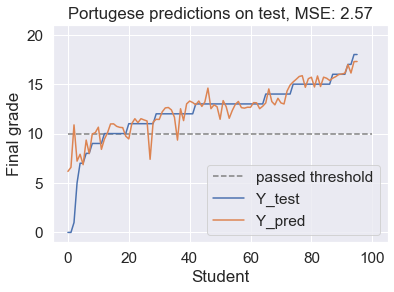

In [162]:
plt.plot((0,100), (10,10), color="gray", linestyle="--", label="passed threshold")
if mat:
    plt.plot(Y_m_test.round(), label = "Y_test")
    plt.title(f"Mathematics predictions on test, MSE: {M2_reg_MSE:.2f}")
    filename = "Results/M1_math_results_grades.png"
else:
    plt.plot(Y_p_test.round(), label = "Y_test")
    plt.title(f"Portugese predictions on test, MSE: {M2_reg_MSE:.2f}")
    filename = "Results/M1_port_results_grades.png"
plt.plot(y_pred_reg, label="Y_pred")
plt.ylim((-1,21))
plt.xlabel("Student")
plt.ylabel("Final grade")
plt.legend();
plt.savefig(filename, dpi=300)

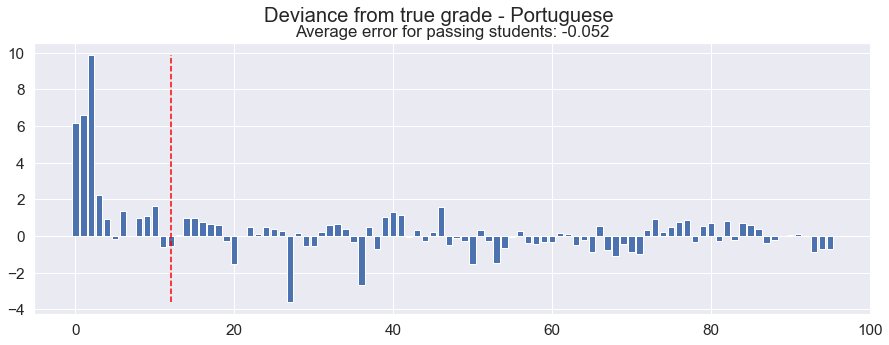

In [186]:
plt.figure(figsize=(15,5))
if mat:
    plt.bar(np.arange(Y_m_test.shape[0]),y_pred_reg- Y_m_test )
    pass_line = np.where(Y_m_test==10)[0][0]
    avg_error = (y_pred_reg- Y_m_test)[pass_line:].mean()
    subject = "Maths"
else:
    vals = y_pred_reg- Y_p_test
    plt.bar(np.arange(Y_p_test.shape[0]),vals )
    pass_line = np.where(Y_p_test==10)[0][0]
    avg_error = (y_pred_reg- Y_p_test)[pass_line:].mean()
    plt.plot((pass_line, pass_line), (vals.min(), vals.max()), color="red", linestyle="--")
    subject = "Portuguese"
plt.suptitle(f"Deviance from true grade - {subject}")
plt.title(f"Average error for passing students: {avg_error:.3f}")
plt.savefig("Results/M1_pred_deviance_"+subject+".png", dpi=300)

# Klassifiseringsmodell: Passed/Failed
Sett `mat_clf`til `True` for å trene modellen på mattekarakterer og til `False` for å trene modellen på portugisiskkarakterer

In [153]:
mat_clf = False

### Grid Search Cross validation

In [154]:
params = { 
    'eta': np.logspace(-2, 0, 10),
    'objective': ['reg:squarederror', 'reg:squaredlogerror', 'reg:logistic', "binary:hinge"],
    'max_depth': np.arange(1,7)
}

In [155]:
GsCV_clf = GridSearchCV(model, params, verbose=1, scoring="neg_mean_squared_error", cv=5)
if mat_clf:
    GsCV_reg.fit(X_train_b, Y_m_train_b)
else:
    GsCV_reg.fit(X_train_b, Y_p_train_b)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:  1.2min finished


In [156]:
clf_model = GsCV_reg.best_estimator_
print(GsCV_reg.best_score_)
print(GsCV_reg.best_params_)

-0.03534490158619684
{'eta': 0.046415888336127774, 'max_depth': 1, 'objective': 'reg:squarederror'}


In [157]:
if mat_clf:
    y_pred_clf = clf_model.predict(X_test_b)[mat_sort_ind_b]
    M2_clf_MSE = mean_squared_error(Y_m_test_b, y_pred_clf)
else:
    y_pred_clf = clf_model.predict(X_test_b)[por_sort_ind_b]
    M2_clf_MSE = mean_squared_error(Y_p_test_b, y_pred_clf)

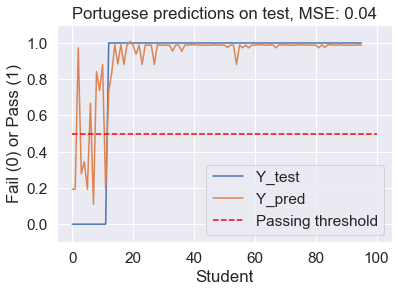

In [158]:
#plt.plot(y_pred_clf.round(), label="Y_pred_rounded",alpha=0.7,color="blue")

if mat_clf:
    plt.plot(Y_m_test_b, label = "Y_test")
    plt.title(f"Mathematics predictions on test, MSE: {M2_clf_MSE:.2f}")
    filename = "Results/M1_math_results_binary_plot.png"
else:
    plt.plot(Y_p_test_b, label = "Y_test")
    plt.title(f"Portugese predictions on test, MSE: {M2_clf_MSE:.2f}")
    filename = "Results/M1_port_results_binary_plot.png"
plt.plot(y_pred_clf, label="Y_pred")
plt.plot((0,100), (0.5, 0.5), label="Passing threshold", linestyle="--", color="red")
plt.ylim((-0.1,1.1))
plt.xlabel("Student")
plt.ylabel("Fail (0) or Pass (1)")
plt.legend();
plt.savefig(filename, dpi=300)

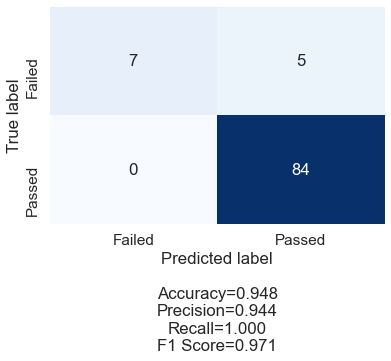

In [159]:
if mat_clf:
    cf = confusion_matrix(Y_m_test_b, y_pred_clf.round())
    filename = "Results/M1_math_results_binary_cfm.png"
else:
    cf = confusion_matrix(Y_p_test_b, y_pred_clf.round())
    filename = "Results/M1_port_results_binary_cfm.png"
make_confusion_matrix(cf, categories=['Failed', 'Passed'], cbar=False, percent=False)
plt.savefig(filename, dpi=300)